# System Identification with NeuroMANCER: Duffing Parameter

This is an interactive notebook based on `duffing_parameter.py`. We demonstrate how the NeuroMANCER toolbox can be used for parameter estimation of the [Duffing ODE system](https://en.wikipedia.org/wiki/Duffing_equation) using stochastic gradient descent (SGD).

## NeuroMANCER and Dependencies

### Install (Colab only)

Skip this step when running locally.

In [ ]:
!pip install setuptools==61.0.0 pyts torchdiffeq mlflow plum-dispatch
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps

### Import

In [ ]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from neuromancer import slim, psl

In [2]:
from neuromancer import blocks, estimators, dynamics, integrators, ode
from neuromancer.interpolation import LinInterp_Offline
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.constraint import variable
from neuromancer.dataset import get_sequence_dataloaders
from neuromancer.loss import PenaltyLoss
import neuromancer.simulator as sim

# Dataset

In [3]:
torch.manual_seed(0)
device = "cpu"

Load the ground truth dataset by simulating the ODE system.

In [4]:
system = psl.systems['Duffing']
ts = 0.01
nsim = 1000
modelSystem = system(ts=ts, nsim=nsim)
raw = modelSystem.simulate()

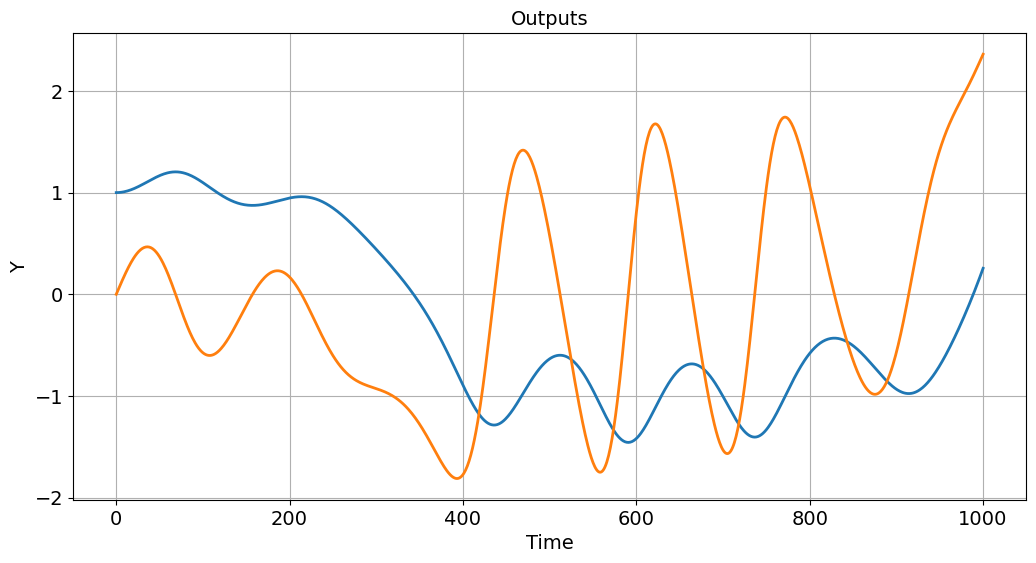

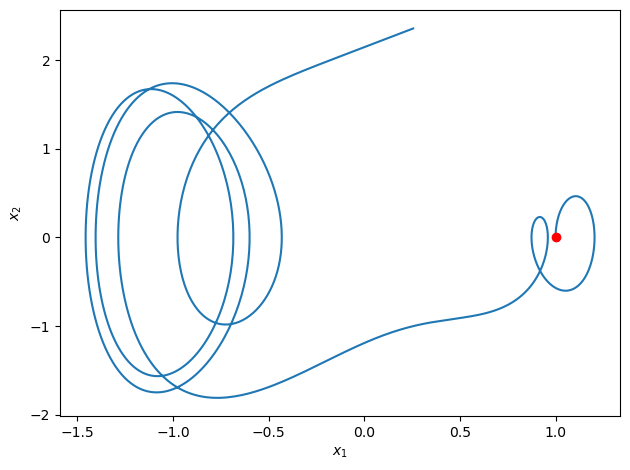

In [5]:
psl.plot.pltOL(Y=raw['Y'])
fig = plt.gcf()
fig.set_size_inches((10,5))
psl.plot.pltPhase(X=raw['Y'])

Interpolate time for the ODE integrator of non-autonomous system

In [6]:
interp_u = lambda tq, t, u: u

Create sequence dataloaders with given prediction horizon.

In [7]:
nsteps = 2
nstep_data, loop_data, dims = get_sequence_dataloaders(raw, nsteps,
                                moving_horizon=True)
train_data, dev_data, test_data = nstep_data    # (nstep, # batches, sys dim)
train_loop, dev_loop, test_loop = loop_data

# check for dataset keys
train_data.dataset.get_full_batch().keys()

dict_keys(['Xp', 'Yp', 'Xf', 'Yf', 'name'])

# System Model

## State Estimator

In [8]:
# Fully observable state estimator as identity mapping
nx = dims['X'][1]
estim = estimators.FullyObservable(
    {**train_data.dataset.dims, "x0": (nx,)},
    linear_map=slim.maps['identity'],
    input_keys=["Yp"])
# test forward pass of the estimator
estim(train_data.dataset.get_full_batch())

{'x0_fully_observable': tensor([[ 1.0000,  0.0000],
         [ 1.0001,  0.0200],
         [ 1.0004,  0.0399],
         [ 1.0009,  0.0598],
         [ 1.0016,  0.0796],
         [ 1.0025,  0.0992],
         [ 1.0036,  0.1187],
         [ 1.0049,  0.1380],
         [ 1.0063,  0.1570],
         [ 1.0080,  0.1757],
         [ 1.0099,  0.1942],
         [ 1.0119,  0.2122],
         [ 1.0141,  0.2300],
         [ 1.0165,  0.2473],
         [ 1.0190,  0.2642],
         [ 1.0218,  0.2806],
         [ 1.0246,  0.2965],
         [ 1.0277,  0.3119],
         [ 1.0309,  0.3267],
         [ 1.0342,  0.3409],
         [ 1.0377,  0.3545],
         [ 1.0413,  0.3675],
         [ 1.0450,  0.3797],
         [ 1.0489,  0.3913],
         [ 1.0529,  0.4021],
         [ 1.0569,  0.4122],
         [ 1.0611,  0.4215],
         [ 1.0654,  0.4300],
         [ 1.0697,  0.4376],
         [ 1.0741,  0.4444],
         [ 1.0786,  0.4504],
         [ 1.0831,  0.4554],
         [ 1.0877,  0.4595],
         [ 1.0923,  

## Dynamics Model

In [9]:
# use either ODE or MLP RHS (uncomment)
duffing_sys = ode.DuffingParam()  # ODE RHS
# duffing_sys = blocks.MLP(insize=nx+1, outsize=nx, hsizes=[32, 32])  # MLP RHS

In [10]:
# ODE integrator
fx_int = integrators.RK4(duffing_sys, interp_u=interp_u, h=modelSystem.ts)
fy = slim.maps['identity'](nx, nx)  # output model

# component class mapping symbolic variables
dynamics_model = dynamics.ODENonAuto(fx_int, fy, 
input_key_map={"x0": estim.output_keys[0]}, name='dynamics')

# Variables

In [11]:
# symbolic NeuroMANCER variables
yhat = variable(dynamics_model.output_keys[2])
y = variable("Yf")

# composite variables
yFD = (y[:, 1:, :] - y[:, :-1, :])
yhatFD = (yhat[:, 1:, :] - yhat[:, :-1, :])

# Objectives

In [12]:
fd_loss = 2.0*((yFD == yhatFD)^2)
fd_loss.name = 'FD_loss'

reference_loss = ((yhat == y)^2)
reference_loss.name = "ref_loss"

# NeuroMANCER Differentiable Problem

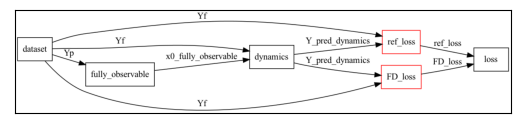

In [13]:
objectives = [reference_loss, fd_loss]
constraints = []
components = [estim, dynamics_model]

# create optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct parametric optimization problem
problem = Problem(components, loss)
problem = problem.to(device)
# plot computational graph
problem.plot_graph()

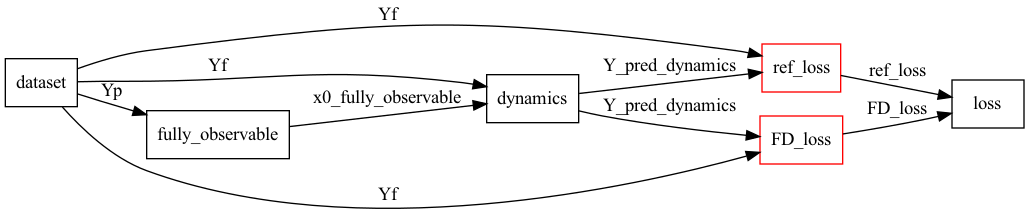

In [14]:
Image('problem_graph.png')

# Train

In [15]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.1)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout="nstep_dev_"+reference_loss.output_keys[0])
trainer = Trainer(
    problem,
    train_data,
    dev_data,
    test_data,
    optimizer,
    patience=20,
    warmup=100,
    epochs=200,
    eval_metric="nstep_dev_"+reference_loss.output_keys[0],
    train_metric="nstep_train_loss",
    dev_metric="nstep_dev_loss",
    test_metric="nstep_test_loss",
    logger=logger,
    device=device,
)

None
Number of parameters: 1


In [16]:
best_model = trainer.train()
best_outputs = trainer.test(best_model)

epoch: 0	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01940	eltime:  0.17139
epoch: 1	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01795	eltime:  0.18508
epoch: 2	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01641	eltime:  0.19787
epoch: 3	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01485	eltime:  0.21043
epoch: 4	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01342	eltime:  0.22433
epoch: 5	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01232	eltime:  0.23768
epoch: 6	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01171	eltime:  0.25461
epoch: 7	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01157	eltime:  0.27216
epoch: 8	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01179	eltime:  0.28466
epoch: 9	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01225	eltime:  0.29873
epoch: 10	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01286	eltime:  0.31108
epoch: 11	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01355	eltime:  0.32276
epoch: 12	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01423	eltime:  0.33504
epoch: 13	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01485	eltime:  0.34704
epoch: 14	nstep_dev_Y_pred_dynamics_eq_Yf: 0.01534	eltime:

# Test Open-Loop Performance

NeuroMANCER `sim` classes act as wrappers for arbitrary callables to be jointly simulated via `sim.SystemSimulator`. This setup facilitates benchmarking and pipelines with heterogenous models.

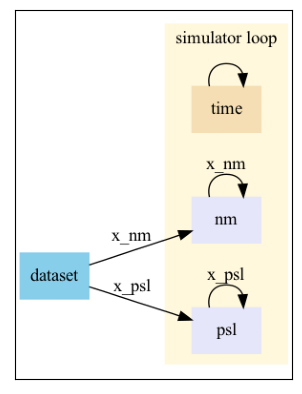

In [17]:
sim_steps = 400
nm_system = sim.DynamicsNeuromancer(dynamics_model,
                name='nm', input_key_map={'x': 'x_nm'})
psl_system = sim.DynamicsPSL(modelSystem,
                name='psl', input_key_map={'x': 'x_psl'})
psl_system.model.ts = ts
components = [nm_system, psl_system]
system = sim.SystemSimulator(components)
system.plot_graph()

## Plot Open-Loop Trajectories

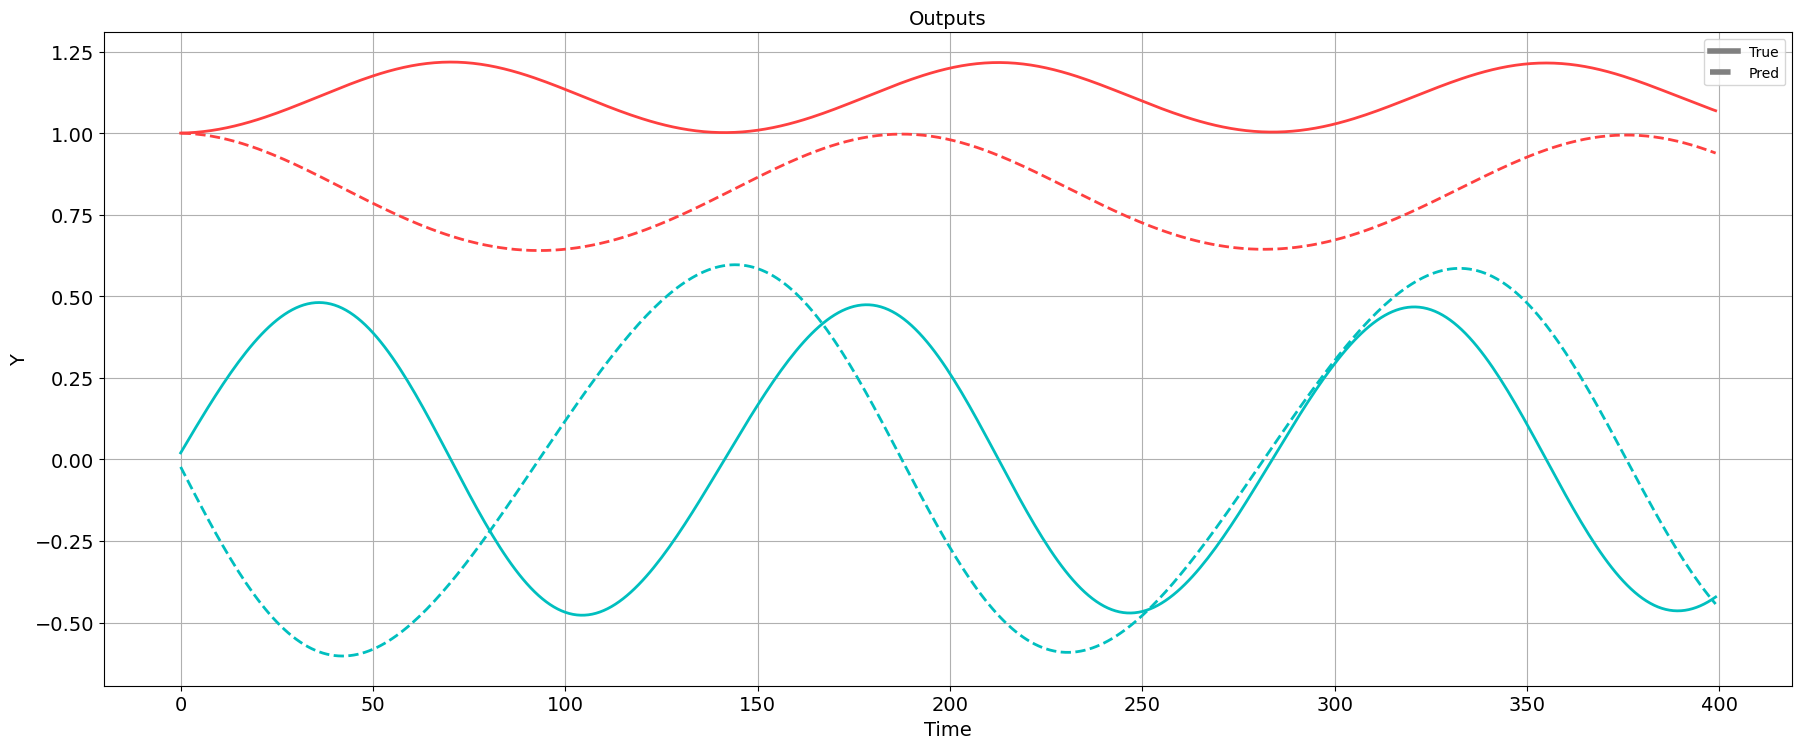

In [18]:
x0 = np.asarray(modelSystem.x0)
data_init = {'x_psl': x0, 'x_nm': x0}
trajectories = system.simulate(nsim=sim_steps, data_init=data_init)
psl.plot.pltOL(Y=trajectories['y_psl'], Ytrain=trajectories['y_nm'])
fig = plt.gcf()
fig.set_size_inches(18,7)